# WTTE-pipeline : data-munging template


Simple pipeline. Take by-timestamp records-data, aggregate over larger timeinterval (discretize) and reshape to tensor. 


# Example pipe

FLOW :
1. Munge df
    - want id,time to be unique
    - want to know start and end of sequence
    - want to have reasonable time-resolution (ex aggregate over days)
2. Padd with zeros for days between observations
3. Embed in fix-format tensor via rightpadding
4. Calculate censoring indicators and time to event
5. Train, Predict, Enjoy


### Meta-example: Tensorflow commit data
```
    git clone https://github.com/tensorflow/tensorflow.git
    cd tensorflow
    FILENAME="tensorflow.csv"

    echo commit,author_name,time_sec,subject,files_changed,lines_inserted,lines_deleted>../$FILENAME;

    git log --oneline --pretty="_Z_Z_Z_%h_Y_Y_\"%an\"_Y_Y_%at_Y_Y_\"%<(79,trunc)%f\"_Y_Y__X_X_"  --stat    \
        | grep -v \| \
        | sed -E 's/@//g' \
        | sed -E 's/_Z_Z_Z_/@/g' \
        |  tr "\n" " "   \
        |  tr "@" "\n" |sed -E 's/,//g'  \
        | sed -E 's/_Y_Y_/, /g' \
        | sed -E 's/(changed [0-9].*\+\))/,\1,/'  \
        | sed -E 's/(changed [0-9]* deleti.*-\)) /,,\1/' \
        | sed -E 's/insertion.*\+\)//g' \
        | sed -E 's/deletion.*\-\)//g' \
        | sed -E 's/,changed/,/' \
        | sed -E 's/files? ,/,/g'  \
        | sed -E 's/_X_X_ $/,,/g'  \
        | sed -E 's/_X_X_//g' \
        | sed -E 's/ +,/,/g' \
        | sed -E 's/, +/,/g'>>../$FILENAME;
```     
[... or cheat](https://gist.github.com/ragulpr/18c6dd75a768330985e024a93539d6bf#file-tensorflow-csv)

For details about WTTE-RNN, check out

https://ragulpr.github.io/

https://github.com/ragulpr/wtte-rnn

https://github.com/ragulpr/wtte-rnn-examples

http://wtte-rnn.readthedocs.io/en/develop/

Written by Egil Martinsson

MIT license

In [ ]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wtte.tte_util as tte
import wtte.transforms as tr

from wtte.pipelines import data_pipeline
from wtte.plots.misc import timeline_aggregate_plot,timeline_plot

pd.options.display.max_rows = 10
from IPython import display

print('np.__version__',np.__version__)
print('pd.__version__',pd.__version__)
import matplotlib
print('matplotlib.__version__',matplotlib.__version__)
np.random.seed(1)

['commit' 'author_name' 'time_sec' 'subject' 'files_changed'
 'lines_inserted' 'lines_deleted']


b'Skipping line 4293: expected 7 fields, saw 9\nSkipping line 4675: expected 7 fields, saw 9\nSkipping line 4884: expected 7 fields, saw 9\nSkipping line 9078: expected 7 fields, saw 9\nSkipping line 9525: expected 7 fields, saw 9\nSkipping line 9795: expected 7 fields, saw 9\nSkipping line 9798: expected 7 fields, saw 9\nSkipping line 10776: expected 7 fields, saw 9\nSkipping line 13468: expected 7 fields, saw 9\nSkipping line 13571: expected 7 fields, saw 9\nSkipping line 16584: expected 7 fields, saw 9\nSkipping line 18150: expected 7 fields, saw 9\n'


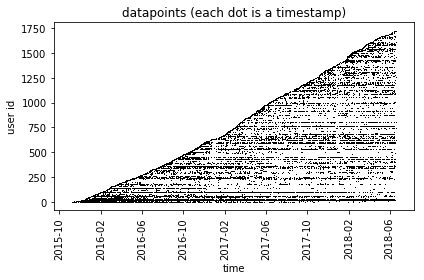

In [2]:

path = "~/Prylar/clones/logs/"
# filename = "amazon-dsstne.csv"
# filename = "caffe.csv"
# filename = "CNTK.csv"
# filename = "convnetjs.csv"
# filename = "deeplearning4j.csv"
# filename = "h2o-3.csv"
# filename = "incubator-singa.csv"
# filename = "keras.csv"
# filename = "mxnet.csv"
# filename = "Paddle.csv"
# filename = "Theano.csv"
# filename = "torch7.csv"
# filename = "veles.csv"
# filename = "linux.csv"
filename = "tensorflow.csv"

df = pd.read_csv(path+filename,error_bad_lines=False,low_memory=False)

print(df.columns.values)
df.fillna(0,inplace=True)

df.rename(columns={"time_sec": "time_int"},inplace=True)
## For transformation df->tensor
id_col='id'
abs_time_col='time_int'
# Put the column indicating 'events' first!
feature_cols= ["n_commits",'files_changed','lines_inserted','lines_deleted']
# feature_cols= ["n_commits"]
constant_cols = []
mean_cols = []

infer_seq_endtime=True
time_sec_interval=60*60*24
timestep_aggregation_dict=dict.fromkeys(feature_cols, "sum")
drop_last_timestep=True


## Create a new sequence-key based on time of first event.
df[id_col] = df.groupby(['author_name'], group_keys=False).\
               apply(lambda g: g.time_int.min().\
               astype(str)+g.author_name.astype(str)).\
               rank(method='dense').astype(int)

df.sort_values([id_col,'time_int'],inplace=True)

df['n_commits'] = 1
# Last observed eventtime is almost always erronous. Ex dates in the future. 
df = df.loc[df['time_int'] < df['time_int'].max()]

plt.scatter(pd.to_datetime(df.time_int,unit='s').values, df.id.values, marker="s", color="black", s=1, linewidths=0,)
# just set x to df.time_int if error "TypeError: invalid type promotion", you're using old matplotlib version.
plt.xticks(rotation='vertical')
plt.title('datapoints (each dot is a timestamp)')
plt.xlabel('time')
plt.ylabel('user id')
plt.tight_layout()
plt.show()

In [3]:
import re
# Aggregates by timestep using sum by default. 
# `constant_cols` and `mean_cols` are aggregated using mean
timestep_aggregation_dict = dict.fromkeys(feature_cols, "sum")
for key in timestep_aggregation_dict:
    for query in list(set().union(constant_cols,mean_cols)):
        if re.match(query+'($|_)', key): # binary cols are formatted as `col_level`
            timestep_aggregation_dict[key] = 'mean'
print('how features will be aggregated each day:')
print(timestep_aggregation_dict)

how features will be aggregated each day:
{'n_commits': 'sum', 'files_changed': 'sum', 'lines_inserted': 'sum', 'lines_deleted': 'sum'}


## Dataframe to tensor

    1. Lower the resolution of the (int) `abs_time_col` ex from epoch sec to epoch day by aggregating\
      each column using `timestep_aggregation_dict`.

    2. Padds out with zeros between timesteps and fills with value of `constant_cols`.

    3. Infers where the last 'non-event' was, i.e the day that we made the query. This is the time of censoring.

If you think this is too much magic, look out for the next example notebook which will break up the steps.

In [4]:
discrete_time=True
pad_between_steps=True

x, padded_t, seq_ids, df_tmp = \
    data_pipeline(df,
                  id_col=id_col,
                  abs_time_col=abs_time_col,
                  column_names=feature_cols,
                  constant_cols = constant_cols,
                  discrete_time=discrete_time,
                  pad_between_steps=pad_between_steps,
                  infer_seq_endtime=infer_seq_endtime,
                  time_sec_interval=time_sec_interval,
                  timestep_aggregation_dict=timestep_aggregation_dict,
                  drop_last_timestep=drop_last_timestep
                  )
print(x.shape)
df_tmp

(1724, 955, 4)


,id,time_int,n_commits,files_changed,lines_inserted,lines_deleted,t_elapsed
0,1,1446854400,2.0,1972.0,392823.0,958.0,0
1,1,1446940800,2.0,36.0,540.0,515.0,1
2,1,1447027200,7.0,68.0,1888.0,1755.0,2
3,1,1447977600,1.0,1271.0,18402.0,1067.0,13
4,1,1448409600,3.0,322.0,5183.0,2888.0,18
...,...,...,...,...,...,...,...
16761,1722,1529280000,0.0,0.0,0.0,0.0,3
16762,1723,1529020800,1.0,1.0,1.0,0.0,0
16763,1723,1529280000,0.0,0.0,0.0,0.0,3
16764,1724,1529193600,4.0,5.0,1988.0,996.0,0


### The first feature in `x` is the event-indicator

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


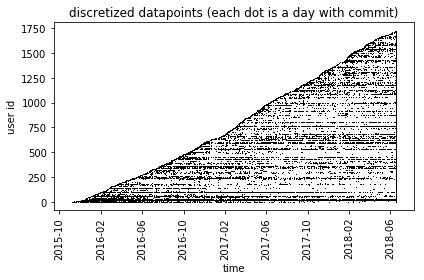

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


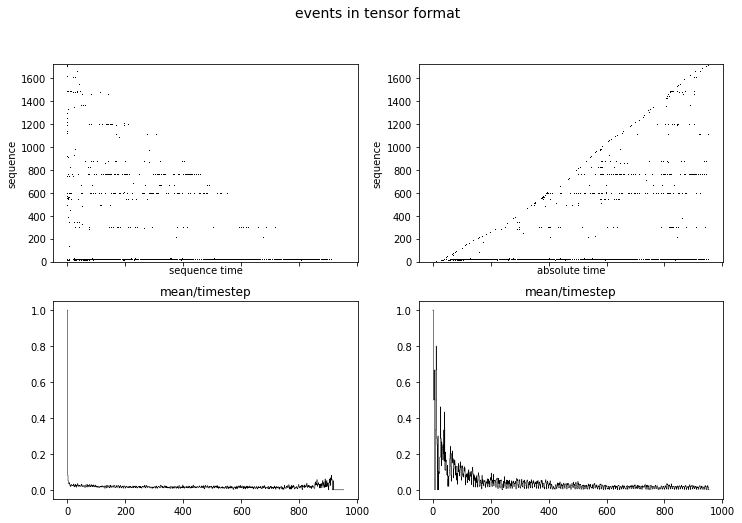

In [5]:
# We assume the first column is the event-indicator:
events = (np.copy(x[:,:,0])>0).astype(float)
events[np.isnan(x[:,:,0])] = np.nan

plt.scatter(pd.to_datetime(df_tmp['time_int'],unit='s').values, df_tmp['id'].values, marker="s", color="black", s=1, linewidths=0,)
plt.xticks(rotation='vertical')
plt.title('discretized datapoints (each dot is a day with commit)')
plt.xlabel('time')
plt.ylabel('user id')
plt.tight_layout()
plt.show()

timeline_aggregate_plot(events,"events in tensor format",cmap="Greys")
plt.show()

# It may seem like the tensor-format is more sparse, but it's actually the same number of events;
assert(np.nansum(df_tmp.n_commits.values>0)==np.nansum(events))

### Example of tensor-feature engineering - global features

- Simply add the mean events per day time series to every timestep where it was known in realtime. (I.e the 'mean/timestep'-series above)

In [6]:
# Add a global feature "mean (number of events) per user today"
add_global_feature = True
if add_global_feature:
    padded = tr.right_pad_to_left_pad(x[:,:,0])
    x_global = np.nanmean(padded,0)
    x_global = np.expand_dims(x_global,0)
    x_global = padded*0+x_global

    x_global =  tr.left_pad_to_right_pad(x_global)
    x = np.concatenate([x,np.expand_dims(x_global,-1)],-1)
    
    feature_cols.append('mean_commits_yesterday')
    del padded,x_global

# If we have count-based (positive) features we can log-squash outliers
only_positive_data = np.nanmin(x)>=0
if only_positive_data:
    print('Using Log')
    x = np.log(1+x)
    

Using Log


## Format tensor for training
* calculate tte-values
* Split into train/test. Some alternatives:
* **Hide the truth from the model** (disalign features and target). 
    - Think *'todays prediction about today and tomorrow is from what happened yesterday'*
* normalize (using training data)

In [7]:
def drop_n_last_timesteps(padded,n_timesteps_to_drop,remove_empty_seqs = True):
    # brutal method: simply right align all tensors and simply cut off the last n_timesteps_to_drop
    n_timesteps = x.shape[1]
    padded      = tr.left_pad_to_right_pad(tr.right_pad_to_left_pad(padded)[:,:(n_timesteps-n_timesteps_to_drop)])
    
    if remove_empty_seqs:
        seq_lengths = tr.get_padded_seq_lengths(padded)
        padded = padded[seq_lengths>0]
    return padded
    
def prep_tensors(x,events):
    # 0. calculate time to event and censoring indicators.
    y  = np.ones([events.shape[0],events.shape[1],2])
    y[:,:,0] = tr.padded_events_to_tte(np.squeeze(events),discrete_time=True)
    y[:,:,1] = tr.padded_events_to_not_censored(np.squeeze(events),discrete_time=True)

    # 1. Disalign features and targets otherwise truth is leaked.
    # 2. drop first timestep (that we now dont have features for)
    # 3. nan-mask the last timestep of features. (that we now don't have targets for)
    events = events[:,1:,]
    y  = y[:,1:]
    x  = np.roll(x, shift=1, axis=1)[:,1:,]
    x  = x + 0*np.expand_dims(events,-1)
    return x,y,events


n_timesteps = x.shape[1]
n_features = x.shape[2]

## Hide frac_timesteps_to_cut of the last timesteps and keep them for testing
frac_timesteps_to_cut = 0.30
n_testing_timesteps = np.floor(n_timesteps*frac_timesteps_to_cut).astype(int)

x_train      = drop_n_last_timesteps(x,n_testing_timesteps)
events_train = drop_n_last_timesteps(events,n_testing_timesteps)

## Do the necessary preparations of the tensors.
x_train,y_train,events_train = prep_tensors(x_train,events_train)
x,y,events    = prep_tensors(x,events)

# Normalize (OPTIONAL for this dataset since it's positive/small magnitive values!)
# if `only_nonzero` only normalize the non-zero entries of the dataset (with coefs from the nonzero obs).
_, means, stds = tr.normalize_padded(x_train,means=None,stds=None,only_nonzero=True)
if only_positive_data:
    means = means*0 # Don't shift, otherwise need to learn "x>0 or x<0 was event"
x_train, _, _ = tr.normalize_padded(x_train,means=means,stds=stds,only_nonzero=True)
x, _, _ = tr.normalize_padded(x,means=means,stds=stds,only_nonzero=True)

seq_lengths = np.count_nonzero(~np.isnan(events), axis=1)
seq_lengths_train = np.count_nonzero(~np.isnan(events_train), axis=1)

# Used for initialization of alpha-bias:
tte_mean_train = np.nanmean(y_train[:,:,0])
mean_u = np.nanmean(y_train[:,:,1])

print('events',events.shape,events.dtype)
print('x min max ',np.nanmin(x),np.nanmax(x))
print('x',x.shape,x.dtype)
print('y',y.shape,y.dtype)
print('x_train',x_train.shape,x_train.dtype)
print('y_train',y_train.shape,y_train.dtype)
print('tte_mean_train: ', tte_mean_train)
print('mean uncensored train: ', np.nanmean(y_train[:,:,1]))

print('x_train size',x_train.nbytes*1e-6,' mb')

events (1724, 954) float64
x min max  0.0 30.909151685085067
x (1724, 954, 5) float64
y (1724, 954, 2) float64
x_train (1154, 668, 5) float64
y_train (1154, 668, 2) float64
tte_mean_train:  158.1288049922537
mean uncensored train:  0.21899387508402646
x_train size 30.83488  mb


## Visualize tensor data

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


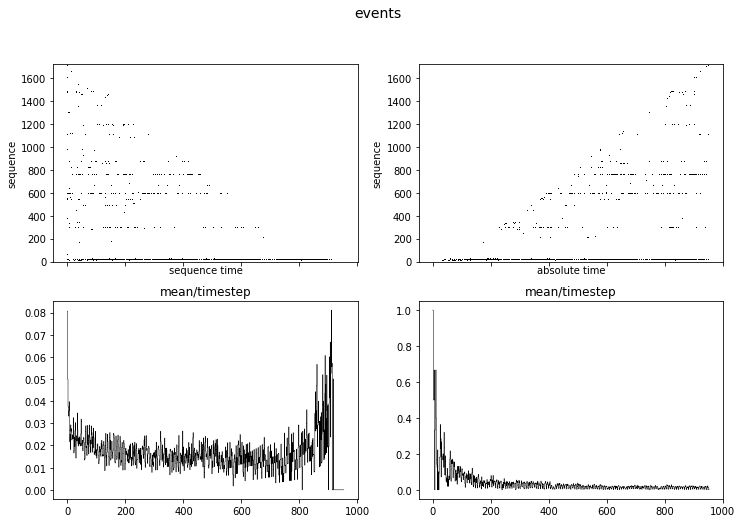

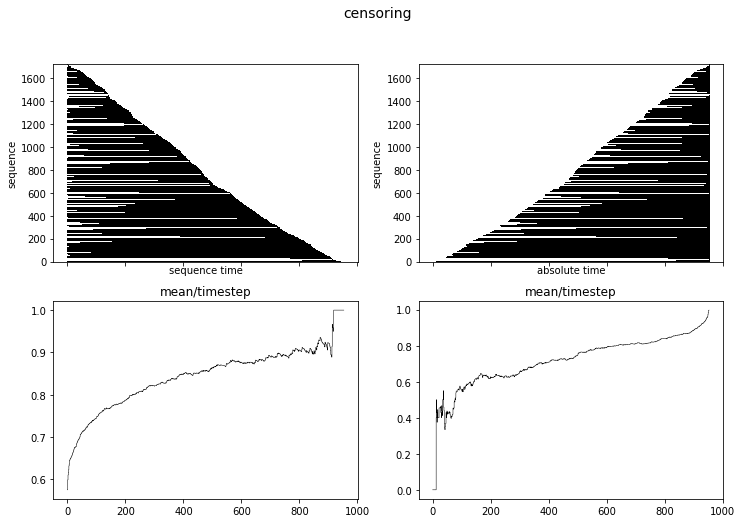

############## TRAINING SET


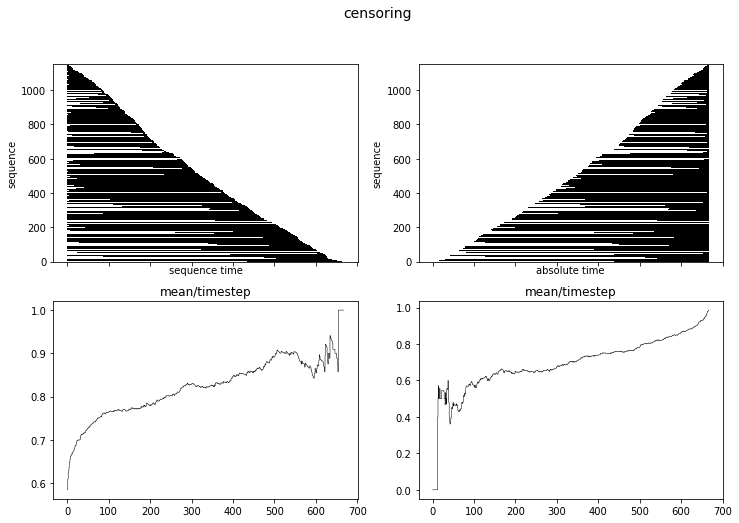

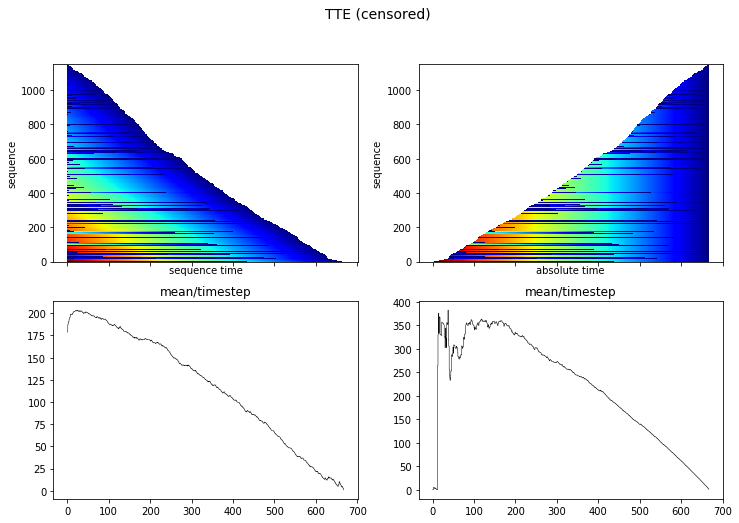

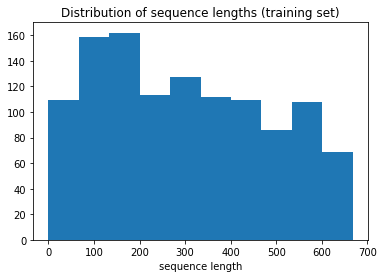

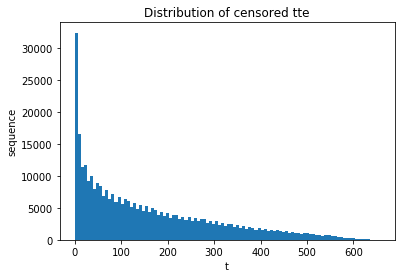

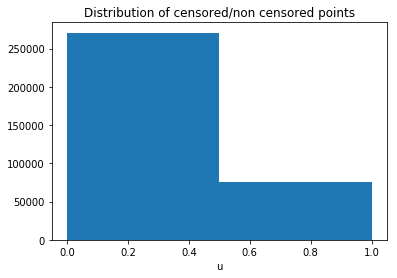

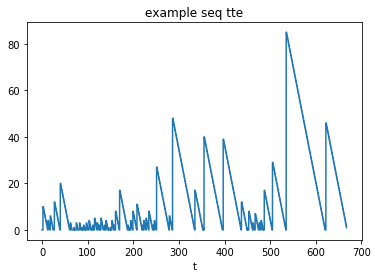

########## features


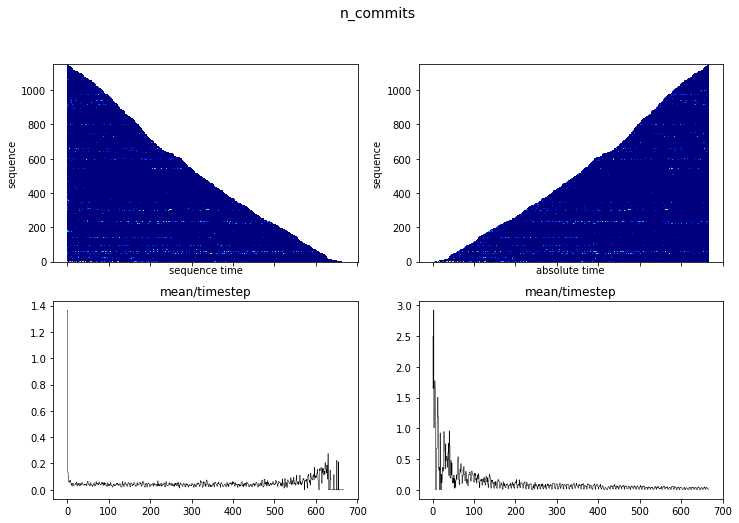

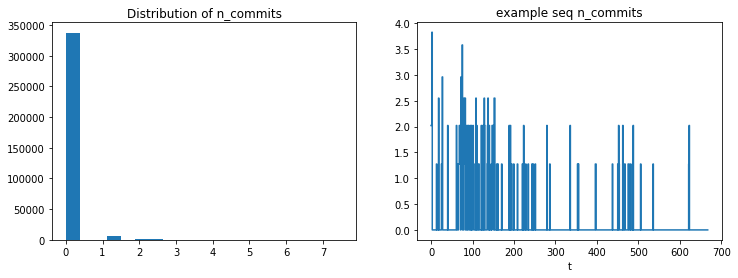

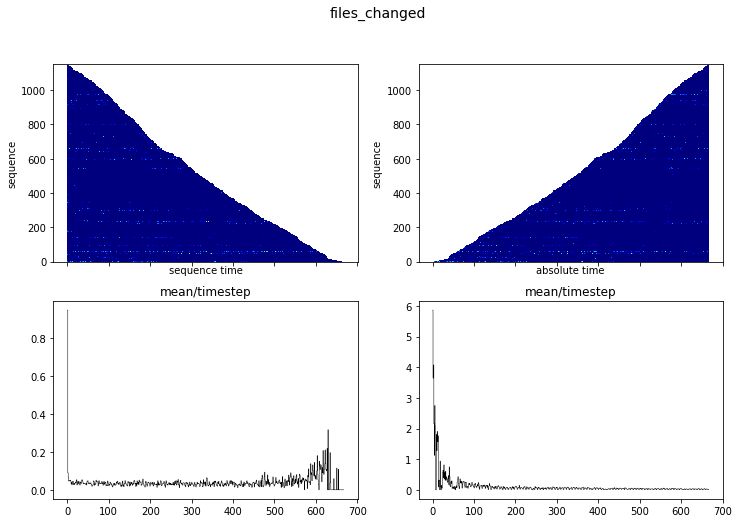

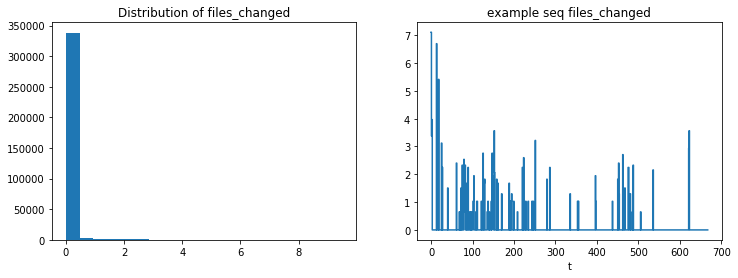

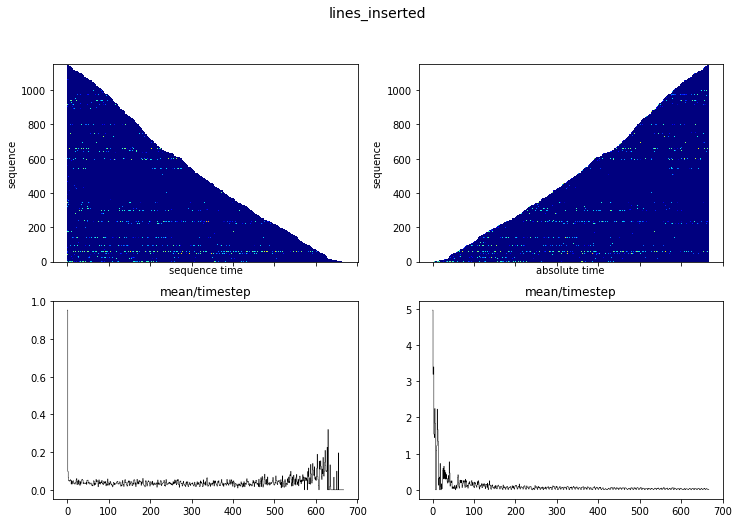

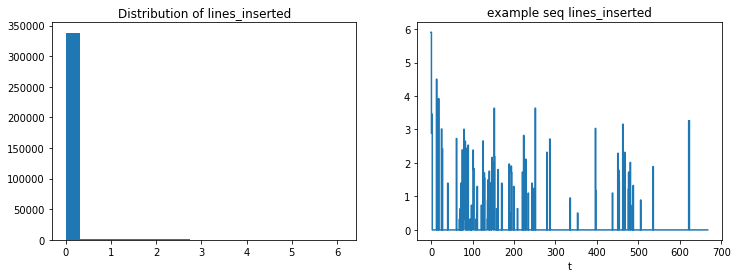

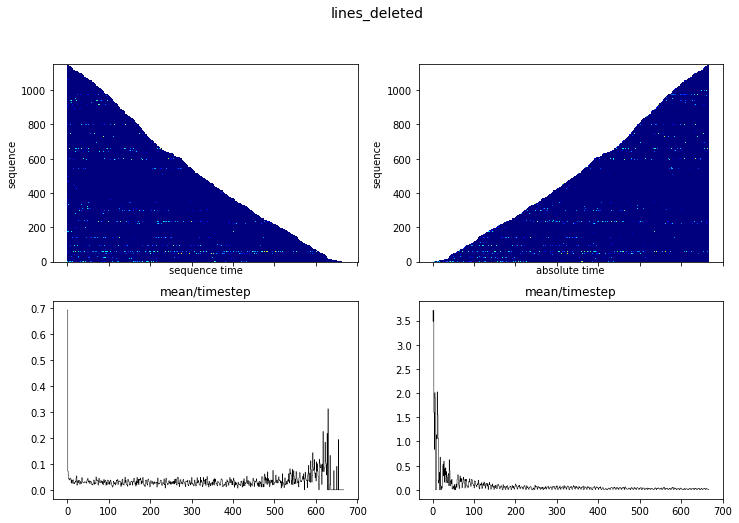

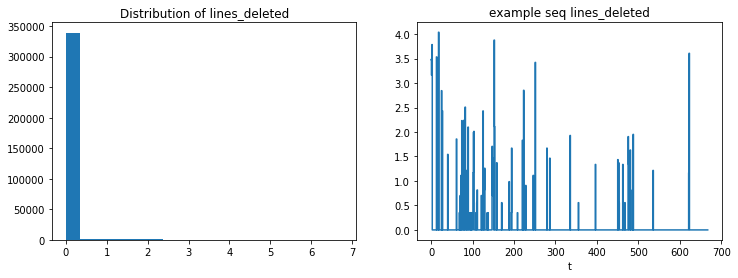

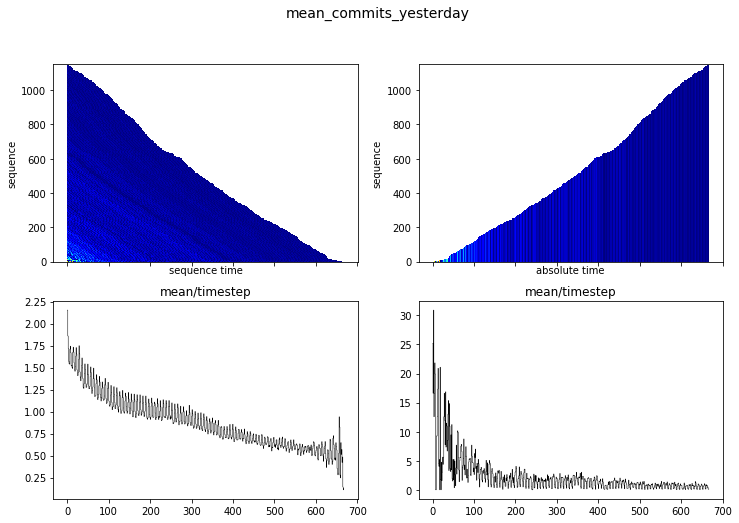

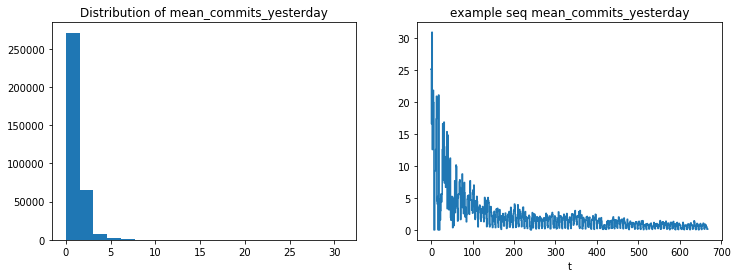

########## 


In [8]:
# def timeline_plot(padded,title='',cmap=None,plot=True,fig=None,ax=None):
#     if fig is None or ax is None:
#         fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(12,4))
    
#     ax[0].imshow(padded,interpolation='none', aspect='auto',cmap=cmap,origin='lower')    
#     ax[0].set_ylabel('sequence');
#     ax[0].set_xlabel('sequence time');
        
#     im = ax[1].imshow(tr.right_pad_to_left_pad(padded),interpolation='none', aspect='auto',cmap=cmap,origin='lower')  
#     ax[1].set_ylabel('sequence');
#     ax[1].set_xlabel('absolute time'); #(Assuming sequences end today)
    
#     fig.suptitle(title,fontsize=14)
#     if plot:
#         fig.show()
#         return None,None
#     else:
#         return fig,ax

# def timeline_aggregate_plot(padded,title='',cmap=None,plot=True):
#     fig, ax = plt.subplots(ncols=2,nrows=2,sharex=True, sharey=False,figsize=(12,8))
    
#     fig,ax[0] = timeline_plot(padded,title,cmap=cmap,plot=False,fig=fig,ax=ax[0])
    
#     ax[1,0].plot(np.nanmean(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
#     ax[1,0].set_title('mean/timestep')
#     padded = tr.right_pad_to_left_pad(padded)
#     ax[1,1].plot(np.nanmean(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
#     ax[1,1].set_title('mean/timestep')

#     fig.suptitle(title,fontsize=14)
#     if plot:
#         fig.show()
#         return None,None
#     else:
#         return fig,ax
    
timeline_aggregate_plot(events,"events",cmap="Greys")
plt.show()

timeline_aggregate_plot(1-y[:,:,1],"censoring",cmap="Greys")
plt.show()

print('############## TRAINING SET')
######
timeline_aggregate_plot(1-y_train[:,:,1],'censoring',cmap='Greys')
plt.show()
timeline_aggregate_plot(y_train[:,:,0],'TTE (censored)',cmap='jet')
plt.show()

train_mask = (False==np.isnan(y_train[:,:,0]))

plt.hist(seq_lengths_train)
plt.title('Distribution of sequence lengths (training set)')
plt.xlabel('sequence length')
plt.show()

plt.hist(y_train[:,:,0][train_mask].flatten(),100)
plt.title('Distribution of censored tte')
plt.ylabel('sequence')
plt.xlabel('t')
plt.show()

plt.hist(y_train[:,:,1][train_mask].flatten(),2)
plt.title('Distribution of censored/non censored points')
plt.xlabel("u")
plt.show()

plt.plot(y_train[0,:,0],drawstyle ='steps-post')
plt.title('example seq tte')
plt.xlabel('t')
plt.show()

print('########## features')
for f in xrange(x_train.shape[2]):
    try:
        feature_name = feature_cols[f]
    except:
        feature_name = '???'
        
    timeline_aggregate_plot(x_train[:,:,f],feature_name,cmap = 'jet')
    plt.show()
    tmp = x_train[:,:,f].flatten()
    fig, ax = plt.subplots(ncols=2,nrows=1,sharex=False, sharey=False,figsize=(12,4))
    ax[0].hist(tmp[False==np.isnan(tmp)],20)
    ax[0].set_title('Distribution of '+feature_name)
    ax[1].plot(x_train[0,:,f],drawstyle ='steps-post')
    ax[1].set_title('example seq '+feature_name)
    ax[1].set_xlabel('t')
    plt.show()
print('########## ')
del tmp,train_mask


## Masks, weights and validation set
Here we validate on test which is sort of unhygienic (there should be train, validation, test)
* Remember, `train` is just whatever's observed until a certain date (here set as 80% of the time since beginning of dataset)
* test (or valid) is whatever's observed after that date
* We only really care about evaluating on a few days after training set ends. Imagine doing a follow up study on predictions made say 1 year after you made them with a model that was trained on the most recent data.


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


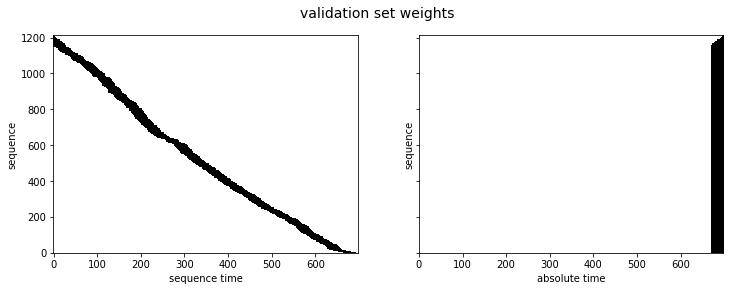

init_alpha:  724.3503024664781 mean uncensored train:  0.21899387508402646
sample_weights_train.shape 	 (1154, 668)
sample_weights_valid.shape 	 (1213, 698)


In [9]:
def nanmask_to_keras_mask(x,y,mask_value,tte_mask):
    """nanmask to keras mask.
        :param float mask_value: Use some improbable telltale value 
                                (but not nan-causing)
        :param float tte_mask: something that wont NaN the loss-function
    """
    # Use some improbable telltale value (but not nan-causing)
    x[:,:,:][np.isnan(x)] = mask_value
    y[:,:,0][np.isnan(y[:,:,0])] = tte_mask
    y[:,:,1][np.isnan(y[:,:,1])] = 0.5
    sample_weights = (x[:,:,0]!=mask_value)*1.
    return x,y,sample_weights

mask_value = -1.3371337 

x_train,y_train,sample_weights_train = nanmask_to_keras_mask(x_train,y_train,mask_value,tte_mean_train)

# Set weights to 0s except some non-nan timesteps immediately after testset ends.
trainset_end = x_train.shape[1]
to_keep = 30 # Only eval first _ timesteps of testset. `to_keep=1` even more realistic if we retrain model nightly.
n_to_drop = x.shape[1]-(trainset_end+to_keep)

x_valid = drop_n_last_timesteps(x.copy(),n_to_drop,remove_empty_seqs = True)
y_valid = drop_n_last_timesteps(y.copy(),n_to_drop,remove_empty_seqs = True)

sample_weights_valid = y_valid[...,0]*0+1 # 1 if not nan
sample_weights_valid = tr.right_pad_to_left_pad(sample_weights_valid)
sample_weights_valid[:,:trainset_end] = sample_weights_valid[:,:trainset_end]*0
sample_weights_valid = tr.left_pad_to_right_pad(sample_weights_valid)
timeline_plot(sample_weights_valid,'validation set weights','Greys')

x_valid,y_valid,_ = nanmask_to_keras_mask(x_valid,y_valid,mask_value,tte_mean_train)

# If there's zero-weight obs the batched model.fit will return NaN loss
sample_weights_valid[np.isnan(sample_weights_valid)] = 0 
m = sample_weights_valid.sum(1)>0
sample_weights_valid = np.copy(sample_weights_valid[m])
x_valid = x_valid[m]
y_valid = y_valid[m]
plt.show()

# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)

print('sample_weights_train.shape \t',sample_weights_train.shape)
print('sample_weights_valid.shape \t',sample_weights_valid.shape) # note: `to_keep` timesteps longer than train

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wtte.tte_util as tte
import wtte.transforms as tr

from wtte.pipelines import data_pipeline
import wtte.tte_util as tte
import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

pd.options.display.max_rows = 20
from IPython import display

import keras.backend as K
from keras.models import Sequential

import keras.layers as L
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Masking
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed
from keras.layers.normalization import BatchNormalization

from keras import callbacks
from keras.optimizers import RMSprop,adam
from keras.models import load_model

import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

import keras
print('keras.__version__',keras.__version__)
try:
    import theano
    print('theano.__version__',theano.__version__)
except:
    pass

def plot_twinaxis(x,y1,y2,xlabel,ylabel1,ylabel2):
    ##### Parameters
    # Create axes
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, y1, color='b')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1)

    ax2.plot(x, y2, color='r')
    ax2.set_ylabel(ylabel2)

    # Change color of each axis
    def color_y_axis(ax, color):
        """Color your axes."""
        for t in ax.get_yticklabels():
            t.set_color(color)
        return None
    color_y_axis(ax1, 'b')
    color_y_axis(ax2, 'r')
    plt.show()
    

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


keras.__version__ 2.1.2
theano.__version__ 1.0.1+unknown


## Architecture
* **Less is more.** I doubt there is much signal in this dataset so architecture will give marginal improvements. If a bottleneck layer is added before the 2-node outputlayer it tends to create more interesting embeddings. Stacked recurrent layers also tend to converge to find a few hidden states (i.e slow moves between clusters in $(\alpha,\beta)$ space.
* **Pretraining helps** Set the bias of the final layer s.t given zero-input it outputs the parametric weibull-estimate of the dataset. Speeds up training and creates numerical stability.


In [11]:
K.set_epsilon(1e-7)
np.random.seed(1)

checkpointer = callbacks.ModelCheckpoint('./model_checkpoint.h5', 
                          monitor='loss', 
                          verbose=1, 
                          save_best_only=True, 
                          save_weights_only=True, 
                          mode='auto', period=50)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
                                        factor  =0.5, 
                                        patience=10, 
                                        verbose=1, 
                                        mode='min', 
                                        epsilon=1e-4, 
                                        cooldown=5, 
                                        min_lr=1e-5)

nanterminator = callbacks.TerminateOnNaN()
history = callbacks.History()
weightwatcher = WeightWatcher(per_batch =False,per_epoch= True)
n_features = x_train.shape[-1]

model = Sequential()
model.add(Masking(mask_value=mask_value,input_shape=(None, n_features)))
# ## TanH input dense/GRU layer activation squashes outliers -> small generalizability effect
model.add(GRU(5,activation='tanh',return_sequences=True,recurrent_dropout=0,unroll=False))

model.add(BatchNormalization(axis=-1, momentum=0.95, epsilon=0.01))
model.add(GRU(30,activation='tanh',return_sequences=True,recurrent_dropout=0,unroll=False))

model.add(BatchNormalization(axis=-1, momentum=0.95, epsilon=0.01))
model.add(L.GaussianDropout(0.05)) # Recurrent dropout + Batchnorm doesn't jive well. This is alternative. 

## GRU or Dense bottleneck-layer before output. Makes interesting embeddings.
# model.add(TimeDistributed(Dense(5,activation='tanh'))) 
model.add(GRU(5,activation='tanh',return_sequences=True,recurrent_dropout=0,unroll=False))

## Wtte-RNN part
model.add(TimeDistributed(Dense(2)))
model.add(Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha, 
                                                "max_beta_value":2.0,
                                                # Stability heuristic: scale by log-number of pre-output layer inputs
                                                "scalefactor":1/np.log(5),
                                               }))

loss_fun = wtte.loss(kind='discrete',reduce_loss=False,clip_prob=1e-5).loss_function
model.compile(loss=loss_fun, optimizer=adam(lr=.01,clipvalue=0.5),sample_weight_mode='temporal')
model.summary()
# model.load_weights("./model.h5")

/usr/local/anaconda3/lib/python3.6/site-packages/keras/layers/core.py:630: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 2)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 5)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 5)           165       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 5)           20        
_________________________________________________________________
gru_2 (GRU)                  (None, None, 30)          3240      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 30)          120       
_________________________________________________________________
gaussian_dropout_1 (Gaussian (None, None, 30)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, None, 5)           540       
__________

/usr/local/anaconda3/lib/python3.6/site-packages/keras/layers/core.py:630: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 2)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


(before  pretrain)	 alpha:  724.3503024664781 	 beta :  1.0
(after  pretrain)	 alpha:  5423.585747754199 	 beta :  0.3900096455975851


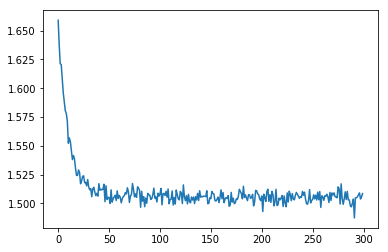

In [12]:
def pretrain_outputlayer(model,x_train,y_train,sample_weights_train,verbose = 0):
    """ Very very smart trick to get the alpha and beta in good location at the beginning.
        Improves numerical stabilitty and speeds up training.
        Basically pretrain the output layer as a parametric model.
        
        Create a separate model for output that only takes zero-input.
        Then pretrain the layer
    """
    nanterminator = callbacks.TerminateOnNaN()
    # input to the final "wtte" output layer
    n_input = model.layers[-2].input_shape[-1]
    
    tmp_model = Sequential()
    tmp_model.add(Masking(mask_value=mask_value,input_shape=(None, n_input)))
    tmp_model.add(model.layers[-2])
    tmp_model.add(model.layers[-1])

#     tmp_model.summary()
    tmp_model.compile(loss=loss_fun, optimizer=adam(lr=1e-2),sample_weight_mode='temporal')    
    
    # Hack to only train the output layer bias; set its input to zero.
    x_tmp = np.zeros([x_train.shape[0],x_train.shape[1],n_input])
    x_tmp[x_train[:,:,0]==mask_value] = mask_value

    predicted = tmp_model.predict(x_tmp[:1,:1]).flatten()
    print('(before  pretrain)\t alpha: ',predicted[0],'\t beta : ',predicted[1])

    history = tmp_model.fit(x_tmp, y_train,
              epochs=300,
              batch_size=100,
              verbose=verbose,
              sample_weight = sample_weights_train,
              callbacks=[nanterminator])
    predicted = tmp_model.predict(x_tmp[:1,:1]).flatten()
    print('(after  pretrain)\t alpha: ',predicted[0],'\t beta : ',predicted[1])
    
    # Copy pretrained weights to the main model (not necessary as it's done by reference)
    model.layers[-2].set_weights(tmp_model.layers[-2].get_weights())
    return history.history['loss']
losses = pretrain_outputlayer(model,x_train,y_train,sample_weights_train,verbose=0)
plt.plot(losses)

In [13]:
K.set_value(model.optimizer.lr, 1e-3)
model.fit(
            x_train, y_train,
            epochs=120,
            batch_size=10,
            verbose=1,
            validation_data=(x_valid, y_valid,sample_weights_valid),
            sample_weight = sample_weights_train,
            callbacks=[nanterminator,history,weightwatcher,reduce_lr,checkpointer]
         )


Train on 1154 samples, validate on 1213 samples
Epoch 1/120
1154/1154 [==============================] - 60s 52ms/step - loss: 1.4421 - val_loss: 1.3986
Epoch 2/120
1154/1154 [==============================] - 54s 47ms/step - loss: 1.4292 - val_loss: 1.4129
Epoch 3/120
1154/1154 [==============================] - 54s 47ms/step - loss: 1.3830 - val_loss: 1.3618
Epoch 4/120
1154/1154 [==============================] - 54s 47ms/step - loss: 1.3725 - val_loss: 1.3589
Epoch 5/120
1154/1154 [==============================] - 51s 44ms/step - loss: 1.3433 - val_loss: 1.3423
Epoch 6/120
1154/1154 [==============================] - 53s 46ms/step - loss: 1.3626 - val_loss: 1.3377
Epoch 7/120
1154/1154 [==============================] - 58s 50ms/step - loss: 1.3348 - val_loss: 1.3280
Epoch 8/120
1154/1154 [==============================] - 57s 49ms/step - loss: 1.3601 - val_loss: 1.3315
Epoch 9/120
1154/1154 [==============================] - 57s 50ms/step - loss: 1.3608 - val_loss: 1.3344
Epoch 1

1154/1154 [==============================] - 58s 50ms/step - loss: 1.2234 - val_loss: 1.2602
Epoch 77/120
1154/1154 [==============================] - 54s 47ms/step - loss: 1.2327 - val_loss: 1.2475
Epoch 78/120
1154/1154 [==============================] - 60s 52ms/step - loss: 1.2028 - val_loss: 1.2626
Epoch 79/120
1154/1154 [==============================] - 56s 49ms/step - loss: 1.2156 - val_loss: 1.2938
Epoch 80/120
1154/1154 [==============================] - 57s 50ms/step - loss: 1.2087 - val_loss: 1.2606
Epoch 81/120
1154/1154 [==============================] - 57s 49ms/step - loss: 1.2326 - val_loss: 1.2561
Epoch 82/120
1154/1154 [==============================] - 58s 50ms/step - loss: 1.2177 - val_loss: 1.2503
Epoch 83/120
1150/1154 [============================>.] - ETA: 0s - loss: 1.2268
Epoch 00083: reducing learning rate to 0.0005000000237487257.
1154/1154 [==============================] - 61s 53ms/step - loss: 1.2230 - val_loss: 1.2657
Epoch 84/120
1154/1154 [===========

#### Visualize training and weights. 
`weightwatcher` keeps track of the output layer weights and biases. If they shoot to infinity its a good pointer that the network is predicting censoring instead of time to event which could lead to instability without early stopping or other remedies.

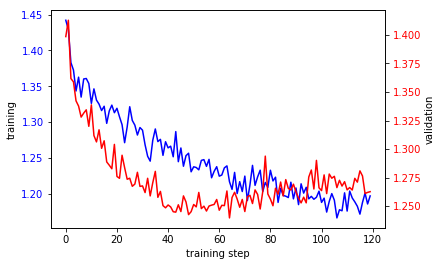

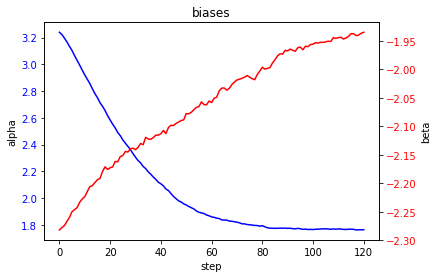

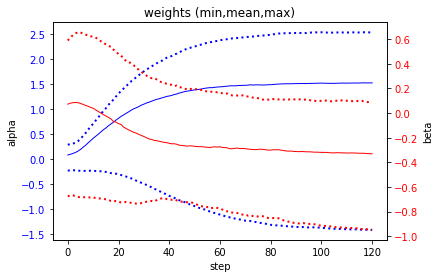

In [14]:
model.save_weights("./model.h5")
plot_twinaxis(x=range(len(history.history['loss'])),
              y1=history.history['loss'],
              y2=history.history['val_loss'],
              xlabel='training step',
              ylabel1='training',
              ylabel2='validation'
             )

# plt.plot(history.history['loss'],    label='training')
# plt.plot(history.history['val_loss'],label='validation')
# plt.legend()
# plt.show()
weightwatcher.plot()

## Predict 

In [15]:
# model.load_weights('./model_checkpoint.h5', by_name=False)
predicted = model.predict(x)
predicted[:,:,1]=predicted[:,:,1]+predicted[:,:,0]*0# lazy re-add of NAN-mask
print(predicted.shape)
print('mean alpha pred\t',np.nanmean(predicted[:,:,0]),'\t(median ',np.nanmedian(predicted[:,:,0]),')')
print('mean beta  pred\t',np.nanmean(predicted[:,:,1]),'\t(median ',np.nanmedian(predicted[:,:,1]),')')

# Here you'd stop after transforming to dataframe and piping it back to some database
tr.padded_to_df(predicted,column_names=["alpha","beta"],dtypes=[float,float])


(1724, 954, 2)
mean alpha pred	 16786.388010647453 	(median  8134.900419589982 )
mean beta  pred	 0.7568110980873787 	(median  0.7748746543011091 )


,id,t,alpha,beta
0,0,0,3764.171346,0.371471
1,0,1,415.617744,0.295511
2,0,2,2929.900226,0.327298
3,0,3,3850.938808,0.286353
4,0,4,5206.246444,0.260617
5,0,5,6548.964567,0.245265
6,0,6,7579.358706,0.236736
7,0,7,7685.980741,0.227623
8,0,8,7997.717945,0.222974
9,0,9,7552.203402,0.224488


## Scatter

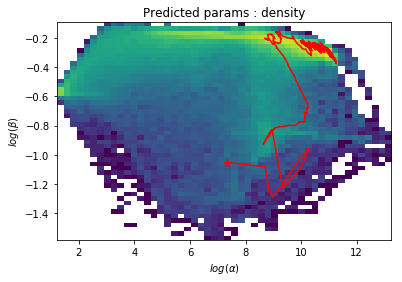

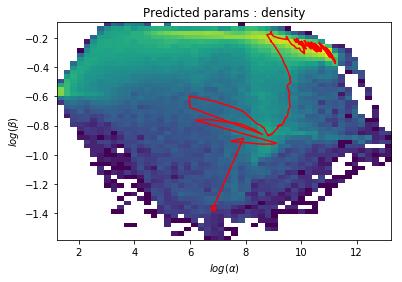

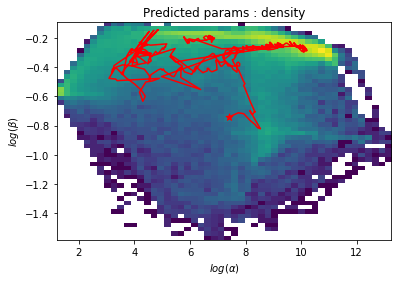

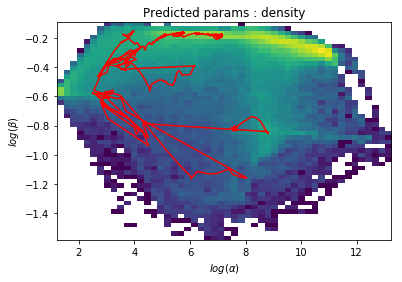

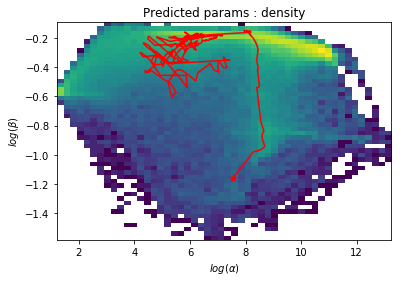

In [16]:
# Pick some random sequence
np.random.seed(9) # seed 6,9,12 interesting
random_selection =np.random.choice(predicted.shape[0], min([5,predicted.shape[0]]))
random_selection = np.sort(random_selection)

_predicted = np.log(predicted)
# Alpha and beta projections
mask = ~np.isnan(_predicted[:,:,0])
alpha_flat = _predicted[:,:,0][mask].flatten()
beta_flat  = _predicted[:,:,1][mask].flatten()

for batch_indx in random_selection:
    from matplotlib.colors import LogNorm
    counts, xedges, yedges, _ = plt.hist2d(alpha_flat, beta_flat, bins=50,norm=LogNorm())
    
    plt.plot(_predicted[batch_indx,:,0],_predicted[batch_indx,:,1],color='red')
    
    plt.scatter(_predicted[batch_indx,0,0],_predicted[batch_indx,0,1],
                marker = '*',
                s=50,
                color='red')
    
    plt.title('Predicted params : density')
    plt.xlim([alpha_flat.min(),alpha_flat.max()])
    plt.ylim([beta_flat.min(),beta_flat.max()])
    plt.xlabel(r'$log(\alpha)$')
    plt.ylabel(r'$log(\beta)$')
    plt.show()
del _predicted, alpha_flat, beta_flat

## Individual sequences

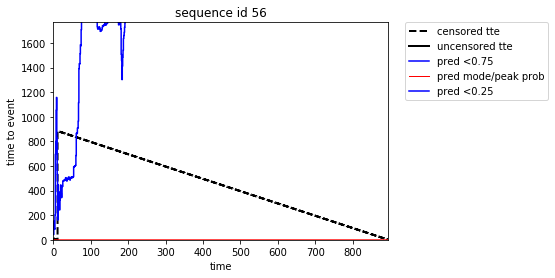

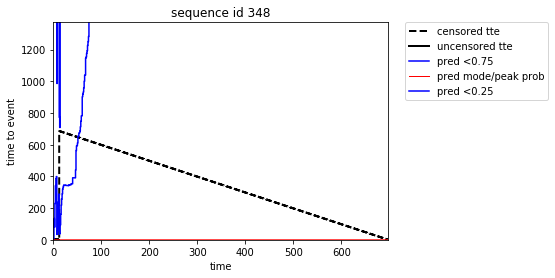

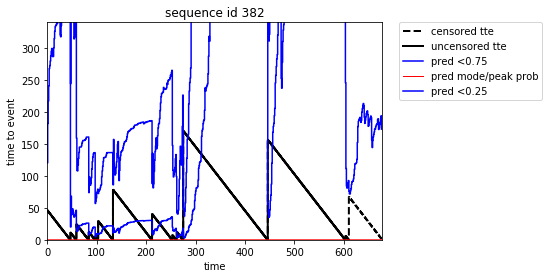

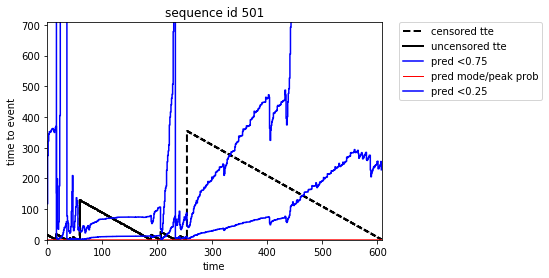

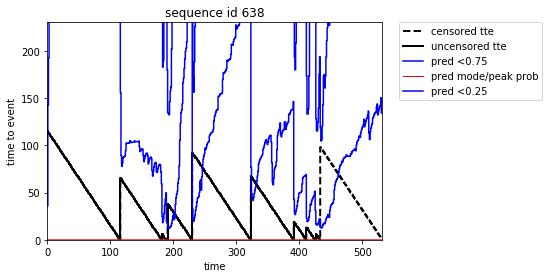

In [17]:
drawstyle = 'steps-post'
for batch_indx in random_selection:
    this_seq_len = seq_lengths[batch_indx]
    a = predicted[batch_indx,:this_seq_len,0]
    b = predicted[batch_indx,:this_seq_len,1]
    t = np.array(xrange(len(a)))
    x_this = x[batch_indx,:this_seq_len,:]

    this_tte = y[batch_indx,:this_seq_len,0]
    u = y[batch_indx,:this_seq_len,1]>0
    
    plt.plot(this_tte,label='censored tte',color='black',linestyle='dashed',linewidth=2,drawstyle=drawstyle)
    if any(u):
        plt.plot(t[u],this_tte[u],label='uncensored tte',color='black',linestyle='solid',linewidth=2,drawstyle=drawstyle)
    
    plt.plot(weibull.quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
    plt.plot(weibull.mode(a, b), color='red',linewidth=1,label='pred mode/peak prob',drawstyle=drawstyle)
#     plt.plot(weibull.mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
    plt.plot(weibull.quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)
    
    plt.xlim(0, this_seq_len)
    plt.ylim(0, min([2*this_tte.max(),2*a.max()]))
    plt.xlabel('time')
    plt.ylabel('time to event')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('sequence id '+str(batch_indx))
    plt.show()


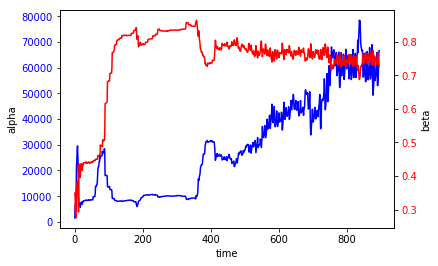

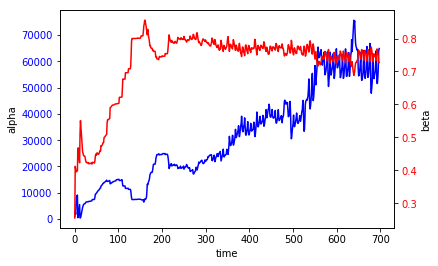

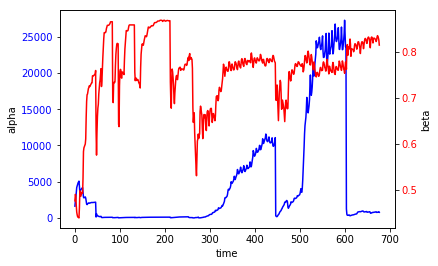

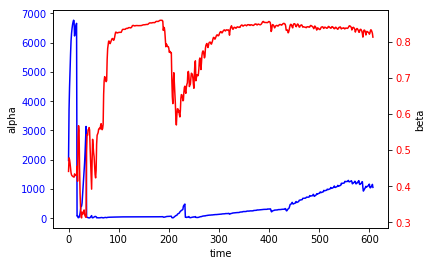

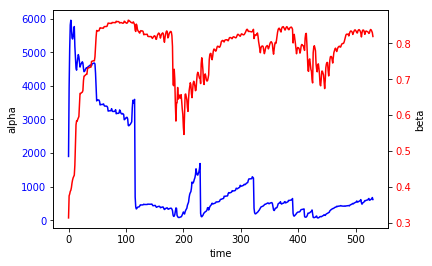

In [18]:
drawstyle = 'steps-post'
for batch_indx in random_selection:
    this_seq_len  = seq_lengths[batch_indx]
    a = predicted[batch_indx,:this_seq_len,0]
    b = predicted[batch_indx,:this_seq_len,1]
    t = np.array(xrange(len(a)))

    plot_twinaxis(x=t,y1=a,y2=b,xlabel='time',ylabel1='alpha',ylabel2='beta')

## Density plot 
Warning: Doesn't look impressive/anything at all when we have $\beta$ around $\leq 1$ since pdf is strictly decreasing (hence mode =0) but useful for other datasets. Predicted $\beta\leq 1$ often happens with live things as it means predicted decreasing hazard -> more time that goes since event the longer time we can expect to the next event. Also a general interpretation as exact timing of the next event is hard to predict (which is the case whenever $\beta >> 1$)

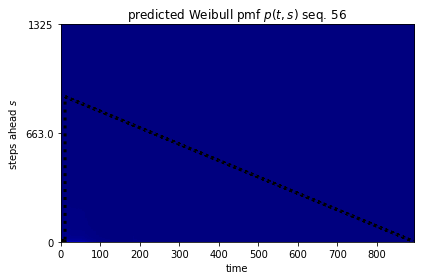

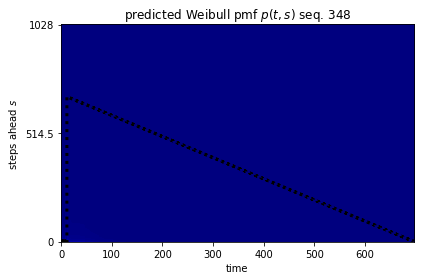

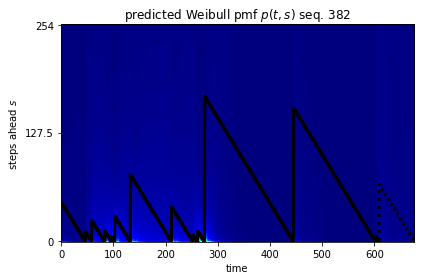

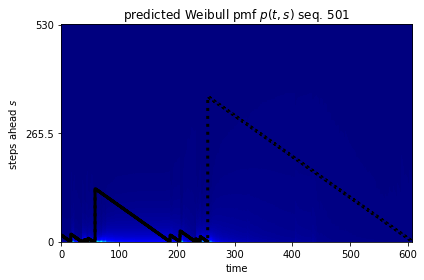

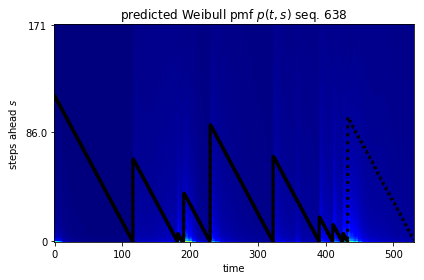

In [19]:
from wtte.plots.weibull_heatmap import weibull_heatmap
for batch_indx in random_selection:
    this_seq_len = seq_lengths[batch_indx]
    if this_seq_len==0:
        next
    a = predicted[batch_indx,:this_seq_len,0]
    b = predicted[batch_indx,:this_seq_len,1]
    t = np.array(xrange(len(a)))
    x_this = x[batch_indx,:this_seq_len,:]

    this_tte = y[batch_indx,:this_seq_len,0]
    censoring_indicator = y[batch_indx,:this_seq_len,1]<1

    fig, ax = plt.subplots(1)

    weibull_heatmap(
        fig,ax,
        t,
        a,
        b,
        max_horizon = int(1.5*this_tte.max()),
        time_to_event=this_tte,
        true_time_to_event=None,
        censoring_indicator = censoring_indicator,
        title='predicted Weibull pmf $p(t,s)$ seq. '+str(batch_indx),
        lw=3.0,
        is_discrete=True,
        resolution=None,
        xax_nbins=10,
        yax_nbins=4 
    )
    plt.show()

# Aggregate view

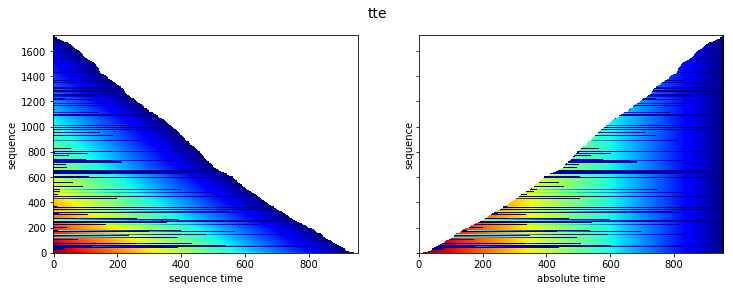

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


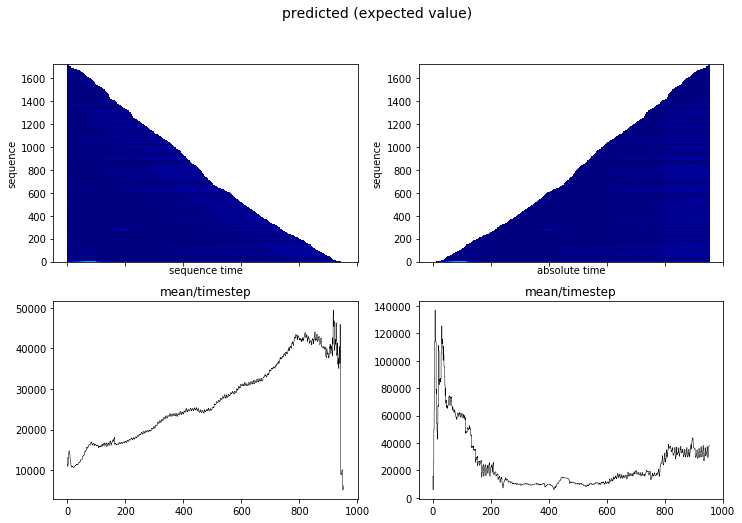

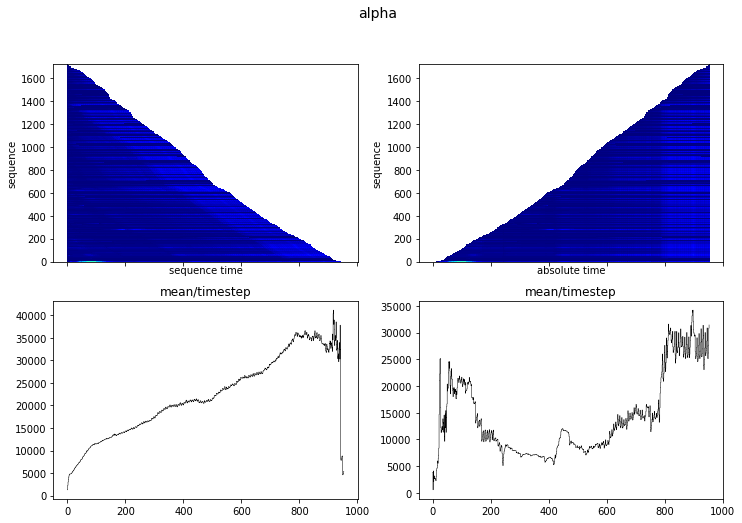

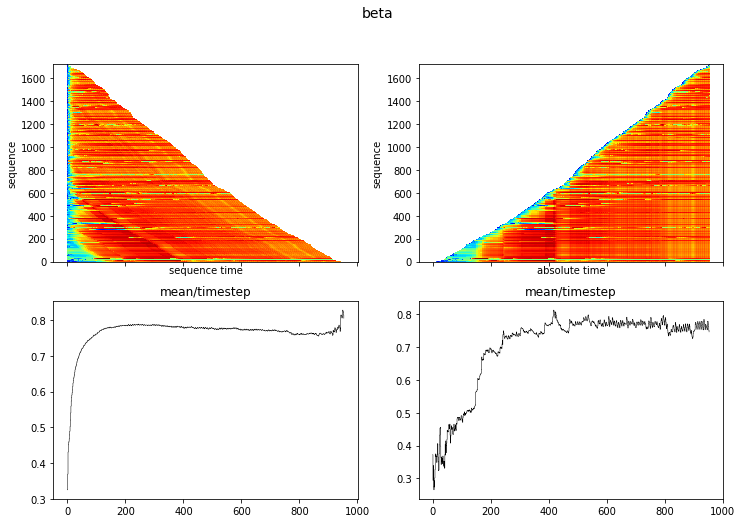

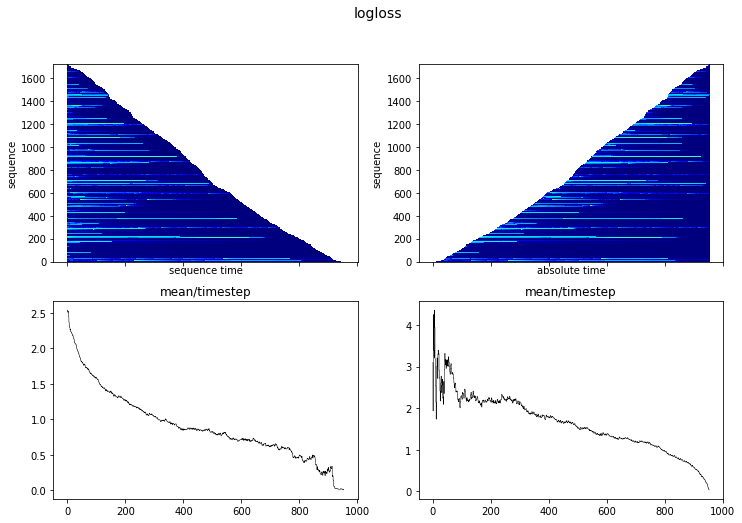

1.2082593075730719 0.0005061094561277074 22.330181505484784


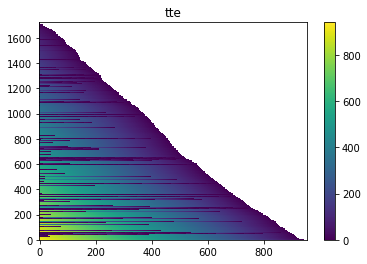

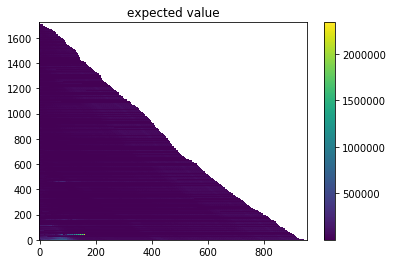

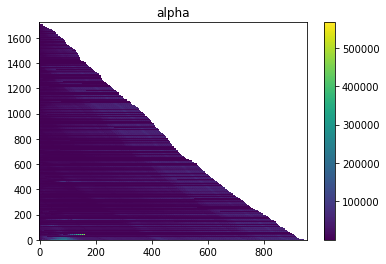

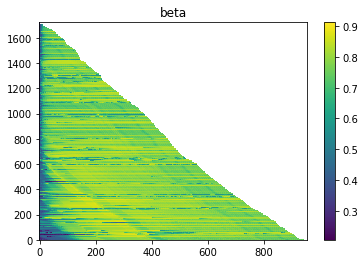

In [20]:
fig,ax = timeline_plot(y[:,:,0],"tte",plot=False)
plt.show()

padded = weibull.mean(a=predicted[:,:,0],b=predicted[:,:,1])
timeline_aggregate_plot(padded,"predicted (expected value)")
plt.show()

timeline_aggregate_plot(predicted[:,:,0],"alpha")
plt.show()

timeline_aggregate_plot(predicted[:,:,1],"beta")
plt.show()

padded = -weibull.discrete_loglik(a=predicted[:,:,0],b=predicted[:,:,1],t=y[:,:,0],u=y[:,:,1],equality=False)
timeline_aggregate_plot(padded,"logloss")
plt.show()
padded = padded[~np.isnan(y[:,:,0])]
print(padded.mean(),padded.min(),padded.max())

plt.imshow(y[:,:,0],aspect='auto',interpolation="none",origin='lower')  
plt.title('tte')
plt.colorbar()
plt.show()

padded = weibull.mean(a=predicted[:,:,0],b=predicted[:,:,1])
plt.imshow(padded,aspect='auto',interpolation="none",origin='lower')  
plt.title('expected value')
plt.colorbar()
plt.show()

plt.imshow(predicted[:,:,0],aspect='auto',interpolation="none",origin='lower')  
plt.title('alpha')
plt.colorbar()
plt.show()
plt.imshow(predicted[:,:,1],aspect='auto',interpolation="none",origin='lower')  
plt.title('beta')
plt.colorbar()
plt.show()

# Performance: Calibration & Discrimination

# Evaluated like a sliding box 
**Remember: Pointwise-prediction is useless**. What we really want to know is whether predicted *distribution* is reasonable. This is a simple method of doing so.

Given that we seldom have the truth due to censored data we partly need to rely on the log-loss. Calibration gives us a hint too. A more intuitive feel is to see what the AUC would have been if it was evaluated as a prediction of whether theres an event within a fixed-window. See 'sliding box' https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/#sliding-box-model

*Note* this is dependent on constant sample_weights. Weighted measure TODO

* [Expected Calibration Error](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4410090/) A measure of how calibrated binary probability predictions are.
* Evaluation setting below: Think train on data until a certain date (with target censored at that point), then evaluate when predicting the date after.
* In real world we *only* care about the evaluation 1 step after training set ends as one typically retrains model every day but here we use more timesteps.
* Expected Calibration Error = 0 -> perfectly calibrated probabilities, 1 -> perfectly wrong
* AUC 0.5 -> not better than random, AUC = 1 -> perfect separation, AUC =0 -> perfect inverse separation
* Early stopping typically improves calibration while hurting discrimination (AUC)


box width	 0 	 auc: 0.9702 	 ECE: 0.0056 	(%in_box: 0.0156 	 1154  obs)
box width	 10 	 auc: 0.9621 	 ECE: 0.0172 	(%in_box: 0.0563 	 1154  obs)
box width	 20 	 auc: 0.9541 	 ECE: 0.0172 	(%in_box: 0.0789 	 1154  obs)
box width	 30 	 auc: 0.9489 	 ECE: 0.015 	(%in_box: 0.0927 	 1154  obs)
box width	 40 	 auc: 0.9478 	 ECE: 0.0164 	(%in_box: 0.1005 	 1154  obs)
box width	 50 	 auc: 0.9434 	 ECE: 0.0166 	(%in_box: 0.1066 	 1154  obs)
box width	 60 	 auc: 0.9351 	 ECE: 0.0169 	(%in_box: 0.1153 	 1154  obs)
box width	 70 	 auc: 0.9271 	 ECE: 0.0184 	(%in_box: 0.1222 	 1154  obs)
box width	 80 	 auc: 0.9258 	 ECE: 0.0208 	(%in_box: 0.1274 	 1154  obs)
box width	 90 	 auc: 0.9181 	 ECE: 0.023 	(%in_box: 0.1343 	 1154  obs)
box width	 100 	 auc: 0.9032 	 ECE: 0.0305 	(%in_box: 0.1412 	 1154  obs)
box width	 110 	 auc: 0.9012 	 ECE: 0.034 	(%in_box: 0.1456 	 1154  obs)
box width	 120 	 auc: 0.8974 	 ECE: 0.0318 	(%in_box: 0.1508 	 1154  obs)
box width	 130 	 auc: 0.8941 	 ECE: 0.033 	(%in_box:

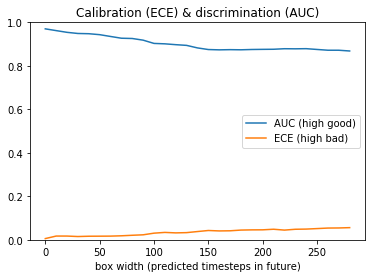

In [21]:
from sklearn import metrics
def binned_prob(label,prob,K=10):
    a = -1
    predicted = []
    expected = []
    frac_in_bin = []
    for i in range(K):
        b = (i+1)/K
        in_interval = ((a<prob)*(prob<=b))>0
        if in_interval.any():
            expected.append(label[in_interval].mean())
            predicted.append(prob[in_interval].mean())
        else:
            expected.append(0)
            predicted.append(0)
        a = b
        frac_in_bin.append(in_interval.mean())
    expected,predicted,frac_in_bin = [np.array(arr) for arr in [expected,predicted,frac_in_bin]]
    return expected,predicted,frac_in_bin

def expected_calibration_error(label,prob,K=10):
    # See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4410090/
    expected,predicted,frac_in_bin = binned_prob(label,prob,K)
    return (frac_in_bin*np.abs(expected-predicted)).sum()

aucs =[]
eces =[]
box_widths =[]

# Evaluate on timesteps after training set end.
n_timesteps = y.shape[1]# ==seq_lengths.max()
testset_begin = y_train.shape[1]# ==seq_lengths_train.max()
# We can use a box-width 0,...,n_timesteps-trainset_end
max_box_width = n_timesteps-testset_begin

# 
predicted_tmp = tr.right_pad_to_left_pad(predicted)
tte_tmp = tr.right_pad_to_left_pad(y[...,0])

# Select datapoints at the first timestep after training set ends.
alpha      = predicted_tmp[:,testset_begin,0]
beta       = predicted_tmp[:,testset_begin,1]
tte        = tte_tmp[:,testset_begin]
m = ~np.isnan(tte+alpha+beta) # nan-mask

for box_width in xrange(max_box_width):
    if (box_width%10)==0:
        if m.sum()==0:
            break
        is_in_box = (tte<=box_width)[m].flatten()
        pred_prob_in_box   = weibull.cmf(a=alpha[m],b=beta[m],t=box_width).flatten()
        
        ece = expected_calibration_error(is_in_box,pred_prob_in_box)
        fpr,tpr,thresholds = metrics.roc_curve(is_in_box,pred_prob_in_box)
        auc = metrics.auc(fpr,tpr)
        print('box width\t',box_width,'\t auc:',round(auc,4),'\t ECE:',round(ece,4),'\t(%in_box:',round(is_in_box.mean(),4),'\t',m.sum(),' obs)')
        aucs.append(auc)
        eces.append(ece)
        box_widths.append(box_width)
        
plt.plot(box_widths,aucs,label='AUC (high good)')
plt.plot(box_widths,eces,label ='ECE (high bad)')
plt.ylim(0,1)
plt.legend()
plt.xlabel('box width (predicted timesteps in future)')
plt.title('Calibration (ECE) & discrimination (AUC)')
plt.show()

# Esoteric plots

## Animate predicted churn
Those with alpha higher than at the their last step is red. Red stream of blood going to the right corner are predicted churners

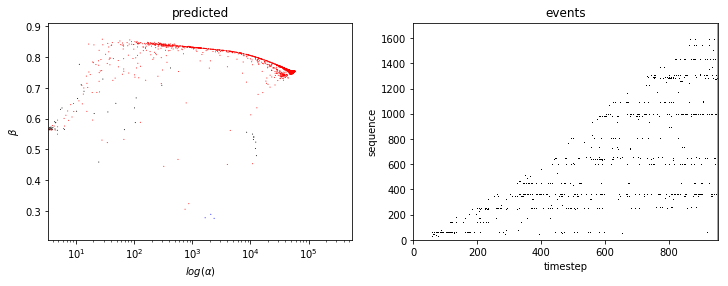

In [22]:
#### Walk through the timeline and look at the embedding.
# by day
padded = tr.right_pad_to_left_pad(predicted)
events_tmp = tr.right_pad_to_left_pad(events)
# by day since signup
# padded = np.copy(predicted)                            
# events_tmp = np.copy(events)
    
fig, ax = plt.subplots(ncols=2, sharey=False,figsize=(12,4))
cmap = None

ax[1].imshow(events_tmp,interpolation='none', aspect='auto',cmap='Greys',origin='lower')
ax[1].set_title('events');
ax[1].set_ylabel('sequence');
ax[1].set_xlabel('timestep');
ln= ax[1].axvline(x=0,c="red",linewidth=.5,zorder=10)


xlims = [np.nanmin(padded[:,:,0]),np.nanmax(padded[:,:,0])]
ylims = [np.nanmin(padded[:,:,1]),np.nanmax(padded[:,:,1])]
seq_timestep = np.cumsum(np.isnan(padded[:,:,0]),1)

for timestep in xrange(0,predicted.shape[1]):
    if timestep%10:
        continue
    ax[0].cla()

#     from matplotlib.colors import LogNorm
#     m = ~np.isnan(padded[:,timestep,0])
#     ax[0].hist2d(np.log(padded[m,timestep,0]), padded[m,timestep,1], bins=50,norm=LogNorm())
        
    if timestep == 0:
        colors = 'blue'
        this_pred = padded[:,0,:]
    else:
        m = ~np.isnan(padded[:,timestep,0])
        this_pred = padded[m,timestep,:]
    
        alpha_larger = padded[m,timestep-1,0]<padded[m,timestep,0]
        
        # blue : first step
        # Black : same or lower alpha
        # Red : higher alpha
        colors = np.repeat('black',len(alpha_larger))
        colors[alpha_larger] = 'red'
        colors[np.isnan(padded[m,timestep-1,0])] = 'blue'
    
    ax[0].scatter(this_pred[:,0],
                  this_pred[:,1],
                color = colors,
                s=1,
                linewidths=0
               )
    
    ax[0].set_xlim(xlims)
    ax[0].set_ylim(ylims)
    ax[0].set_xscale("log", nonposx='clip')
    
    ax[0].set_title('predicted');
    ax[0].set_xlabel(r'$log(\alpha)$')
    ax[0].set_ylabel(r'$\beta$')

    ln.remove()
    ln= ax[1].axvline(x=timestep,c="red",linewidth=.5,zorder=10)

#     fig_name = './figures/'+format(timestep,'05d')
#     fig.savefig(fig_name,bbox_inches='tight',transparent=False,dpi=100)
#     plt.gcf()
    display.display(plt.gcf())
    display.clear_output(wait=True)

del seq_timestep,xlims,ylims,events_tmp

# Conclusions
- The network becomes fairly good at recognizing death (hence shifting the distribution up when its apparent they'r not coming back). This is partly a form of artifact learning, partly a good thing.
- Many have been puzzled why its a reverse jigsaw-pattern in the prediction (while tte/target is actually going down). As it longer time passes from an event, the more likely it is that the user is dead hence the alpha goes up. I.e the model learned a reasonable heuristic.

## Remedies for predicted tte = infinity
- Long sequences have more timesteps hence more influence so one can weight sequences according to length.
- Clipping log-likelihood. Default by wtte v1.05. Effectively stops distribution to be moved if whenever likelihood of observation is above 1-eps_prob
- Don't use remedies. The fact that some observations have expected values going to infinity may be what we want: to predict *churn*.
